<a href="https://colab.research.google.com/github/GemmaGorey/Dissertation/blob/main/Dissertation_GG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial Colab setup below - Run  top two cells once only per session**


In [6]:
!pip install -q condacolab
import condacolab
condacolab.install()
# installs mamba to use instead of pip

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [1]:
# Create the config file and build the environment.
yaml_content = """
name: dissertation
channels:
  - pytorch
  - conda-forge
dependencies:
  - python=3.11
  - pytorch=2.2.2
  - torchvision=0.17.2
  - torchaudio
  - librosa
  - numpy<2
  - pandas
  - jupyter
  - wandb
"""

# Write the string content to a file -  'environment.yml'.
with open('environment.yml', 'w') as f:
    f.write(yaml_content)

print("environment.yml file created successfully.")

# create the environment using mamba from the yml file.
print("\n Creating environment")

!mamba env create -f environment.yml --quiet && echo -e "\n 'dissertation' environment is ready to use."

environment.yml file created successfully.

 Creating environment
Channels:
 - pytorch
 - conda-forge
Platform: linux-64
Solving environment: ...working... done
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... 

done

 'dissertation' environment is ready to use.


In [2]:
# imports and setting up of GitHub and W&B

# clone project repository from GitHub
print("⏳ Cloning GitHub repository...")
!git clone https://github.com/GemmaGorey/Dissertation.git
print("Repository cloned.")

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#imports
import pandas as pd
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

⏳ Cloning GitHub repository...
fatal: destination path 'Dissertation' already exists and is not an empty directory.
Repository cloned.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#loading in the dataset -using complete which has the lyrics and music.



# create string for path to where dataset lives
data_path = '/content/drive/MyDrive/dissertation/MERGE_Bimodal_Complete/'

# load the files

print("Loading MERGE Metadata ")
merge_df = pd.read_csv(data_path + 'merge_bimodal_complete_metadata.csv')

print("\n Loading Valence-Arousal values")
av_df = pd.read_csv(data_path + 'merge_bimodal_complete_av_values.csv')


print("\n Datasets loaded successfully.")

# Inspect the files
print("\n First 5 rows of the data")
display(merge_df.head())

print("\n First 5 rows of the MERGE AV Values")
display(av_df.head())

Loading MERGE Metadata 

 Loading Valence-Arousal values

 Datasets loaded successfully.

 First 5 rows of the data


,Audio_Song,Lyric_Song,Quadrant,AllMusic Id,AllMusic Extraction Date,Artist,Title,Relevance,Year,LowestYear,...,ThemeWeights,Styles,StyleWeights,AppearancesTrackIDs,AppearancesAlbumIDs,Sample,SampleURL,ActualYear,num_Genres,num_MoodsAll
0,A001,L051,Q4,MT0000291374,New,Louis Armstrong,What a Wonderful World,NaN,NaN,NaN,...,"9,9",NaN,NaN,NaN,NaN,NaN,NaN,1968,NaN,NaN
1,A002,L052,Q4,MT0001577585,Old,Rod Stewart,Country Comfort,1.493585,1970-??-??,NaN,...,"5,5,5,5,5,5,5,5","Adult Contemporary,Contemporary Pop/Rock","5,5","MT0001577585,MT0002372349,MT0002706336,MT00029...","MW0000073575,MW0000100670,MW0000100670,MW00001...",1.0,http://rovimusic.rovicorp.com/playback.mp3?c=s...,1970,NaN,NaN
2,A003,L053,Q3,MT0008469560,New,Stevie Wonder,Lately,NaN,NaN,NaN,...,"7,8,9,9,9",NaN,NaN,NaN,NaN,NaN,NaN,1980,NaN,NaN
3,A004,L054,Q3,MT0030326044,New,Johnny Cash,I'm So Lonesome I Could Cry,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960,NaN,NaN
4,A005,L055,Q1,MT0005204984,New,Prince,U Got the Look,NaN,NaN,NaN,...,"8,8,8,9,9,9",NaN,NaN,NaN,NaN,NaN,NaN,1987,NaN,NaN



 First 5 rows of the MERGE AV Values


,Audio_Song,Lyric_Song,Arousal,Valence
0,A001,L051,0.29375,0.89375
1,A002,L052,0.33750,0.68125
2,A003,L053,0.25000,0.22500
3,A004,L054,0.20000,0.18125
4,A005,L055,0.78750,0.68750


In [4]:
# merging the two dataframes using the common column

final_df = pd.merge(merge_df, av_df, left_on='Audio_Song', right_on='Audio_Song')

print(" DataFrames merged")

print("\n First 5 rows  MASTER DataFrame")
display(final_df.head())

 DataFrames merged

 First 5 rows  MASTER DataFrame


,Audio_Song,Lyric_Song_x,Quadrant,AllMusic Id,AllMusic Extraction Date,Artist,Title,Relevance,Year,LowestYear,...,AppearancesTrackIDs,AppearancesAlbumIDs,Sample,SampleURL,ActualYear,num_Genres,num_MoodsAll,Lyric_Song_y,Arousal,Valence
0,A001,L051,Q4,MT0000291374,New,Louis Armstrong,What a Wonderful World,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1968,NaN,NaN,L051,0.29375,0.89375
1,A002,L052,Q4,MT0001577585,Old,Rod Stewart,Country Comfort,1.493585,1970-??-??,NaN,...,"MT0001577585,MT0002372349,MT0002706336,MT00029...","MW0000073575,MW0000100670,MW0000100670,MW00001...",1.0,http://rovimusic.rovicorp.com/playback.mp3?c=s...,1970,NaN,NaN,L052,0.33750,0.68125
2,A003,L053,Q3,MT0008469560,New,Stevie Wonder,Lately,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1980,NaN,NaN,L053,0.25000,0.22500
3,A004,L054,Q3,MT0030326044,New,Johnny Cash,I'm So Lonesome I Could Cry,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1960,NaN,NaN,L054,0.20000,0.18125
4,A005,L055,Q1,MT0005204984,New,Prince,U Got the Look,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1987,NaN,NaN,L055,0.78750,0.68750


In [5]:
#checking data - in different quadrants
print(final_df['Quadrant'].value_counts())

Quadrant
Q2    673
Q1    525
Q4    518
Q3    500
Name: count, dtype: int64


In [6]:
#checking data
print(final_df[['Valence', 'Arousal']].describe())

           Valence      Arousal
count  2216.000000  2216.000000
mean      0.505027     0.482316
std       0.231149     0.139533
min       0.018750     0.062500
25%       0.293750     0.370625
50%       0.398750     0.506250
75%       0.738906     0.578750
max       0.987500     0.975000


In [7]:
#checking no blank entries
print(final_df[['Quadrant', 'Valence', 'Arousal']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Quadrant  2216 non-null   object 
 1   Valence   2216 non-null   float64
 2   Arousal   2216 non-null   float64
dtypes: float64(2), object(1)
memory usage: 52.1+ KB
None


In [11]:
def load_song_data(song_id, lyric_id, quadrant):
    """
    Loads the audio and lyrics for a given song ID
    """
    print(f"Attempting to load song: {song_id}")
    try:
        # Construct the file path to google drive
        base_path = '/content/drive/MyDrive/dissertation/MERGE_Bimodal_Complete'

        # Audio files url addition as these are in subfolders for each emotion quadrant
        audio_path = os.path.join(base_path, 'audio', quadrant, f"{song_id}.mp3")

        # Lyric files url addition as these are in a separate main folder
        lyrics_path = os.path.join(base_path, 'lyrics', quadrant, f"{lyric_id}.txt")

        # load the audio file
        audio_waveform, sample_rate = librosa.load(audio_path, sr=None) #preserve original sample rate

        #Process Audio into a Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_waveform, sr=sample_rate)
        # Convert to decibels
        db_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # load lyrics text
        with open(lyrics_path, 'r', encoding='utf-8') as f:
            lyrics_text = f.read()

        print(f" Successfully loaded {song_id}")
        return db_spectrogram, lyrics_text

    except Exception as e:
        print(f" An error occurred for {song_id}: {e}")
        return None, None





A001
L051
Q4
Attempting to load song: A001
 Successfully loaded A001

--- Lyrics Sample ---
I see trees of green, red roses too
I see them bloom for me and you
And I think to myself what a wonderful world.

I see skies of blue and clouds of white
The bright blessed day, the dark sacred night

--- Spectrogram Data ---
Shape: (128, 1879)


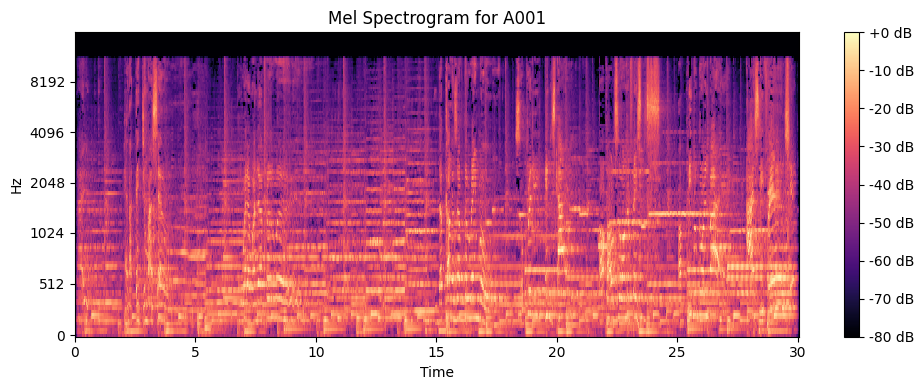

In [19]:
# Get the ID and Quadrant from the first row of your dataframe
test_audio_id = final_df.iloc[0]['Audio_Song']
test_lyric_id = final_df.iloc[0]['Lyric_Song_x']
test_quadrant = final_df.iloc[0]['Quadrant']

print(test_audio_id)
print(test_lyric_id)
print(test_quadrant)

# Call function
spectrogram, lyrics = load_song_data(test_audio_id, test_lyric_id, test_quadrant)


# Check the output to see if it worked - lyrics
if lyrics is not None:
    print("\n--- Lyrics Sample ---")
    print(lyrics[:200]) # This prints the first 200 characters of the lyrics

# Check the output of the audio conversion
if spectrogram is not None:
    print("\n--- Spectrogram Data ---")
    print(f"Shape: {spectrogram.shape}") # This will be a 2D shape now

    # --- Visualize the Spectrogram ---
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=librosa.get_samplerate(path=os.path.join('/content/drive/MyDrive/dissertation/MERGE_Bimodal_Complete/audio', test_quadrant, f'{test_audio_id}.mp3')), x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram for {test_audio_id}')
    plt.tight_layout()
    plt.show()